# Vehicle Detection Project

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled set of images.
* Also apply a color transform and binned color features, as well as histograms of color and append all of them.
* Normalize and randomize training and testing sets.
* Train a Linear SVM classifier.
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


### Setup

Run only these 3 cells and jump to **Load Saved Model** if you have already fitted the Support Vector Machine Model.

#### Imports

In [1]:
import numpy as np

np.random.seed(54321)

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2
import time
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from scipy.ndimage.measurements import label

from tqdm import tqdm_notebook as tqdm
from collections import deque

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext line_profiler

#### Parameters

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb <----
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block <---
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window() <----

slide_window_sizes = [80, 96, 112, 128, 160] # <---
slide_window_overlap = (0.60, 0.60)  # <---

out_img = 'output_images/'
ends_smoothing = 20
starts_smoothing = 5


#### Helper Functions

In [7]:
_HOGDescriptor_cache = { }

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    
    
    k = (pix_per_cell,cell_per_block,orient)
    if k in _HOGDescriptor_cache:
        hogdesc = _HOGDescriptor_cache[k]
    else:
        hogdesc = cv2.HOGDescriptor(
                    (pix_per_cell*cell_per_block, pix_per_cell*cell_per_block),
                    (pix_per_cell*cell_per_block, pix_per_cell*cell_per_block),
                    (pix_per_cell,pix_per_cell),
                    (pix_per_cell,pix_per_cell),
                    orient)
        _HOGDescriptor_cache[k] = hogdesc
        
    img4cv2 = (img*255).astype('uint8')
    f = hogdesc.compute(img4cv2)
    g = f.reshape(f.shape[0])
    return g
    
    # Call with two outputs if vis==True
    # if vis == True:
    #    features, hog_image = hog(img, orientations=orient,
    #                              pixels_per_cell=(pix_per_cell, pix_per_cell),
    #                              cells_per_block=(cell_per_block, cell_per_block),
    #                              transform_sqrt=True,
    #                              visualise=vis, feature_vector=feature_vec)
    #   return features, hog_image
    # Otherwise call with one output
    #else:
    #    features = hog(img, orientations=orient,
    #                   pixels_per_cell=(pix_per_cell, pix_per_cell),
    #                   cells_per_block=(cell_per_block, cell_per_block),
    #                   transform_sqrt=True,
    #                   visualise=vis, feature_vector=feature_vec)
    #    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, bins_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)




### Load the data sets

In [8]:
def load_images():
    images = glob.glob('data/*/*/*.png')
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles/' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars

cars, notcars = load_images()
print(len(cars), len(notcars))

8792 8968


### Extract features from the data sets.

In [9]:

def extract_features(img_files, color_space='RGB', spatial_size=(32, 32),
                      hist_bins=32, bins_range=(0, 256),
                      orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                      spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    # Iterate through the list of images
    for filename in tqdm(img_files):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(filename)
        img_features = single_img_features(image, color_space,
                        spatial_size, hist_bins, bins_range,
                        orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(img_features)
    return features


# reading from PNG bins_range goes from 0 to 1.
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, bins_range=(0, 1),
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

# reading from PNG bins_range goes from 0 to 1.
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, bins_range=(0, 1),
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)


### Normalization and randomization

In [10]:
%%time

print('# of features:', len(car_features[0]))

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# of features: 8460
CPU times: user 8.18 s, sys: 10.2 s, total: 18.4 s
Wall time: 28.3 s


In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


### Train and test Model

In [12]:
%%time

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

svc.fit(X_train, y_train)


Feature vector length: 8460
CPU times: user 16.1 s, sys: 7.08 s, total: 23.2 s
Wall time: 36 s


In [13]:
# Check the score of the SVC
print('Test Accuracy of SVC = {:.2%}'.format(svc.score(X_test, y_test)))

CM = confusion_matrix(y_test, svc.predict(X_test))
print('False positives {:.2%}'.format( CM[0][1] / len(y_test)))
print('False negatives {:.2%}'.format( CM[1][0] / len(y_test)))


Test Accuracy of SVC = 99.01%
False positives 0.34%
False negatives 0.65%


### Save model for reuse.

In [14]:
joblib.dump((svc, X_scaler), 'svc-model.pkl')

['svc-model.pkl']

### Load saved model

In [15]:
svc, X_scaler = joblib.load('svc-model.pkl')

### Search windows

In [16]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # print(nx_windows, ny_windows)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def search_windows_sizes(image, slide_window_sizes,
                    clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
        hot_windows = []
        for xywin in slide_window_sizes:
            xy_window = (xywin, xywin)
            
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                xy_window=xy_window, xy_overlap=slide_window_overlap)

            hot = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
            hot_windows.extend(hot)
        return hot_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



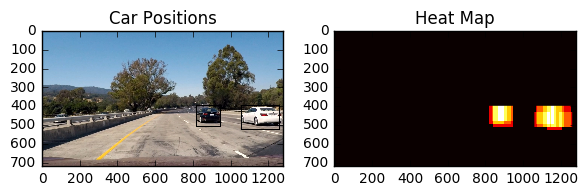

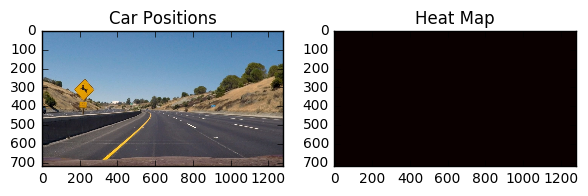

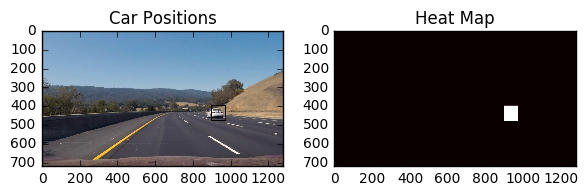

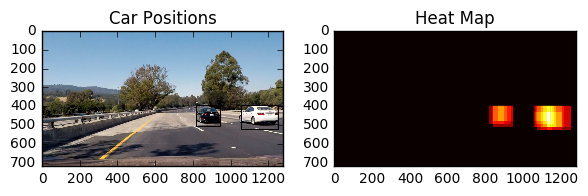

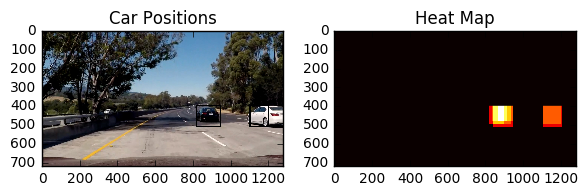

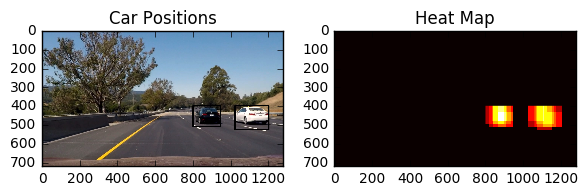

In [17]:
def _test_search():
    image_files = glob.glob('test_images/' + '*.jpg')
    256
    for img_file in image_files:

        image = cv2.imread(img_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # normalize.
        image = image.astype(np.float32)/255
        
        hot_windows = search_windows_sizes(image, slide_window_sizes,
                                svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
        # draw the hot_windows
        # draw_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)

        # will accumulate between frames!
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat, hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()

        plt.show()

_test_search()

### Pipeline

In [18]:

def pipeline(imageori, **params):
    buffer = params['buffer']
    min_smooth = params['min_smooth']
    stats = params['stats']
    
    # normalize.
    image = imageori.astype(np.float32)/255

    hot_windows = search_windows_sizes(image, slide_window_sizes,
                            svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # will accumulate between frames!
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(imageori), labels)

    return result


params = {}

def process_image(img):
    return pipeline(img, **params)

def _test_pipeline():
    params['buffer'] = deque(maxlen=ends_smoothing)
    # no smoothing in per frame test.
    params['min_smooth'] = ends_smoothing
    params['stats'] = {
    }
    
    files = glob.glob('test_images' + '/test*.jpg')
    for i, imgfile in enumerate(files):
        
        imgori = cv2.imread(imgfile)
        imgori = cv2.cvtColor(imgori, cv2.COLOR_BGR2RGB)

        result = process_image(imgori)
        
        print(imgfile)
        # plt.imshow(result)
        # plt.savefig(out_img+'pipeline'+str(i)+'.png')
        # plt.show()

# always test pipeline
%lprun -f single_img_features _test_pipeline()

test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


### Process test video

In [19]:
params['buffer'] = deque(maxlen=ends_smoothing)
params['min_smooth'] = starts_smoothing
params['stats'] = {
}

output_clip = 'vehicle_test.mp4'
clip1 = VideoFileClip("test_video.mp4")
vehicle_detect = clip1.fl_image(process_image)
%time vehicle_detect.write_videofile(output_clip, audio=False)

# print()
# print('Stats:')
# print(params['stats'])


[MoviePy] >>>> Building video vehicle_test.mp4
[MoviePy] Writing video vehicle_test.mp4


 97%|█████████▋| 38/39 [00:55<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_test.mp4 

CPU times: user 54.1 s, sys: 983 ms, total: 55.1 s
Wall time: 59.2 s
